### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# ML model (GOSS-LGBM) for `Total Precipitation`

##  Read Me

This scripts contains ML model building steps for the weather variable `Total Precipitaiton`. The ML model has been implemented using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/) library. Detail on why GOSS has been chosen for ML modeling has been described in `Discussion.ipynb`. 


The modeling involves the following steps-
1. Preparing `ML Model Improved` Predictor Dataset
2. Loading Data
3. Evaluation before model performance/relationship 
4. additional data filtering 
5. train-test data split 
6. Looking into Mutual Information (MI) score to select preliminary input variables
7. Model training + hyperparameter tuning
8. Train-test dataset performance evaluation
9. Evaluating model's predictor importance plot
10. Evaluation model performance for randomly selected dates from the test dataset
11. Estimating overall model perforamcne on test dataset
12. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

__Note:__
- the functions for building ML model, hyperparameter optimization, model performance evaluation, and daily improved-resolution weather data generation (interpolation) can be found at `ML_utils.ipunb` script.
- the functions for building Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets can be found at `NN_Pytorch.ipunb` script.
- the general functions for  for raster data handling, era5/twc data processing/compilation, and folder handling can be found at `general_utils.ipunb` script.

In [2]:
from ipynb.fs.full.general_utils import *
from ipynb.fs.full.ML_utils import *

-------------------------

## 1. Preparing `ML Model Improved` Predictor Dataset

### __Note__

1. Unlike other weather ML models, where we used resampled ERA5 datasets and elevation data as predictors, in `total precipitation` model, we are going to use `ML model interpolated improved 8km` datasets as predictors/input variables. The reason behind this is - directly resampled (8km) ERA5 datasets were not performing well as predictors. Therefore, we decided to include `model improved weather datasets` (min/max/avg temperature, avg wind speed, avg relative humidity) in the input variable dataset (after resampling them to 8km). In addition, we also had other directly resampled ERA5 weather datasets as predictors.

2. The model interpolated datasets are referred to as `ML model improved` datasets. We found good model performance for those ML models after testing them by various threshold. See individual model scripts in the `models` folder for detail. The ML models interpolated the weather datasets to 4km resolution. But `TWC High-Res Precipitation (8km)` data was used as the training data in the `total precipitation` model. So, all input variables needed to be resampled to 8km resolution first. Therefore, we resampled both `model improved weather datasets` and `ERA5 datasets` to 8km to be used in precipitation model.

### 1a. Resampling model (ML) interpolated weather datasets to 8km

Here, we are going through each folder of `ML model improved` datasets (min/max/avg temperature, avg wind speed, avg relative humidity) and resampling them to 8km resolution.

In [4]:
ref_raster_8km = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/total_precip/total_precip_20210101.tif'

input_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_4km'  # model interpolated 4km weather datasets
output_dir = '../../datasets/downscaled_data/8km/weather_data/weather_modeled_resampled_8km'

variables = os.listdir(input_dir)
for var in variables:
    print(f'Processing {var} dataset...')
    datasets = glob(os.path.join(input_dir, var, '*.tif'))
    var_output_dir = os.path.join(output_dir, var)
    
    for data in datasets:
        raster_name = os.path.basename(data).split('.')[0] + '.tif'
        resample_raster_based_on_ref_raster(input_raster=data, ref_raster=ref_raster_8km, 
                                            output_dir=var_output_dir, raster_name=raster_name, 
                                            resampling_alg=Resampling.bilinear)

# making latitude and longitude rasters
print(f'Processing lat, lon dataset...')
ref_raster = glob(os.path.join(output_dir, variables[0], '*.tif'))[0]
print(ref_raster)
ref_arr, ref_file = read_raster_arr_object(ref_raster)
lon_arr, lat_arr = make_lat_lon_array_from_raster(ref_raster)

lon_dir = os.path.join(output_dir, 'lon')
lat_dir = os.path.join(output_dir, 'lat')
makedirs([lon_dir, lat_dir])

write_array_to_raster(raster_arr=lon_arr, raster_file=ref_file, transform=ref_file.transform, 
                      output_path=os.path.join(lon_dir, 'lon.tif'))
write_array_to_raster(raster_arr=lat_arr, raster_file=ref_file, transform=ref_file.transform, 
                      output_path=os.path.join(lat_dir, 'lat.tif'))

Processing avg_wind_speed dataset...
Processing avg_Rhumid dataset...
Processing max_temp dataset...
Processing avg_temp dataset...
Processing min_temp dataset...
Processing lat, lon dataset...
../../datasets/downscaled_data/8km/weather_data/modeled_resampled_8km/avg_wind_speed/avg_wind_speed_20201118.tif


'../../datasets/downscaled_data/8km/weather_data/modeled_resampled_8km/lat/lat.tif'

### 1b. Compiling model (ML) interpolated 8km (resampled from 4km) weather datasets into dataframe

In this step, we are compiling the 8km resampled `ML model improved` datasets into a dataframe.

In [ ]:
compiled_downscaled_df = compile_twc_daily_data_to_dataframe(savename='downscaled_weather_data_8km.parquet', 
                                    twc_data_folder = '../../datasets/downscaled_data/8km/weather_data/weather_modeled_resampled_8km',
                                    output_folder = '../../datasets/processed_parquet_data/cities_California/era5_parquet')

compiling data for avg_wind_speed...
compiling data for avg_Rhumid...
compiling data for max_temp...
compiling data for avg_temp...
compiling data for min_temp...


In [6]:
compiled_downscaled_df.head()

,index,avg_wind_speed,date,year,month,day,lon,lat,avg_Rhumid,max_temp,avg_temp,min_temp
0,2,7.573050,20020101,2002,1,1,-122.252716,39.447643,95.822876,13.457195,11.473993,9.445182
1,3,7.777767,20020101,2002,1,1,-122.180717,39.447643,96.549133,13.673881,11.473097,9.280560
2,4,7.875784,20020101,2002,1,1,-122.108719,39.447643,96.775780,13.615346,11.452966,9.250385
3,5,7.936904,20020101,2002,1,1,-122.036720,39.447643,96.697464,13.734679,11.513138,9.305302
4,6,7.928761,20020101,2002,1,1,-121.964722,39.447643,96.575050,13.852456,11.531980,9.263794


### 1c.  Joining Other Datasets to the `ML Improved Dataset` dataframe 

In this step, we are joining the newly developed `ML Improved Dataset` dataframe with the previously developed (in `processing_daily_weather_data.ipynb`) TWC-ERA5 combined dataframe. The newly developed `ML Improved Dataset` dataframe have overlapping column with the previous dataframe. So, we are going to drop these overlapping columns from the previous dataframe as we already have the improved variables in the newly developed `ML Improved Dataset` dataframe.

In [3]:
# compiled dataframe with modeled (ML generated) weather variable
model_interpolated_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/downscaled_weather_data_8km.parquet'

# Previously compiled data with weather variables from TWC/ERA5/topography
prev_compiled_data= '../../datasets/processed_parquet_data/cities_California/twc_era5_precip_data_cities_California.parquet'

# this is the combined dataframe with some weather variables from ML models and others from TWC/ERA5/topography
combined_dataset = '../../datasets/processed_parquet_data/cities_California/twc_era5_modeled_precip_data_cities_California_updated.parquet'


model_interpolated_df = pd.read_parquet(model_interpolated_data)
prev_compiled_df = pd.read_parquet(prev_compiled_data)

# filtering out index, day, month, year from precip dataframe as they are already in the model interpolated dataframe
# the 'avg_wind_speed', 'avg_Rhumid', 'max_temp', 'min_temp' datasets will come from the model interpolated dataframe
# removing these columns before compiling the dataframes
prev_compiled_df = prev_compiled_df.drop(columns=['index', 'day', 'month', 'year', 
                                                  'avg_wind_speed', 'avg_Rhumid', 'max_temp', 'min_temp'])

combined_df = combine_twc_era5_datasets(twc_dataset=prev_compiled_df, era5_dataset=model_interpolated_df, 
                                        output_file=combined_dataset, 
                                        merge_on=['date', 'lat', 'lon'], how='inner')

print(combined_df.columns)
combined_df.head()

Index(['lon', 'lat', 'total_precip_twc', 'date', 'avg_wind_dir', 'etr',
       'avg_ST_L1', 'avg_snow_depth', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'MaxNet_SR', 'elevation', 'min_Rhumid',
       'min_dew_temp', 'max_atmPress', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip_era5', 'eto', 'min_atmPress', 'slope',
       'avg_Cloud', 'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR',
       'index', 'avg_wind_speed', 'year', 'month', 'day', 'avg_Rhumid',
       'max_temp', 'avg_temp', 'min_temp'],
      dtype='object')


,lon,lat,total_precip_twc,date,avg_wind_dir,etr,avg_ST_L1,avg_snow_depth,avg_atmPress,max_dew_temp,...,TotNet_SR,index,avg_wind_speed,year,month,day,avg_Rhumid,max_temp,avg_temp,min_temp
0,-122.252716,39.372646,0.6,20151201,267.577911,2.115584,7.562662,0.0,1003.335388,1.182468,...,8.401899,10418143,5.528710,2015,12,1,63.103996,14.948964,8.176744,0.877089
1,-122.180717,39.372646,0.6,20151201,274.954559,2.300000,7.615909,0.0,1010.915894,0.613636,...,8.468068,10418144,5.555808,2015,12,1,63.294907,14.947087,7.937225,0.556045
2,-122.108719,39.372646,0.6,20151201,282.331177,2.484416,7.669156,0.0,1018.496399,0.044805,...,8.534237,10418145,5.783466,2015,12,1,63.716599,14.893674,7.551577,0.162149
3,-122.036720,39.372646,1.5,20151201,268.314941,2.576623,7.637013,0.0,1023.681152,-0.324026,...,8.585802,10418146,5.943883,2015,12,1,63.626995,14.906998,7.471014,0.068982
4,-121.964722,39.372646,0.7,20151201,190.120132,2.392208,7.348701,0.0,1021.678589,-0.092857,...,8.593555,10418147,5.577433,2015,12,1,64.910294,14.767276,7.325434,0.011658


### Note********
- Here in the compiled dataframe, the `'index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'avg_temp', 'min_temp'` columns come from the newly developed `ML Improved Dataset` dataframe.
- `'total_precip_twc', 'min_wind_speed', 'total_precip_era5', 'MaxNet_SR', 'elevation', 'min_Rhumid',
   'min_dew_temp', 'max_atmPress', 'avg_wind_dir', 'etr', 'avg_ST_L1',
   'avg_snow_depth', 'max_Rhumid', 'TotDown_SR', 'eto', 'min_atmPress',
   'slope', 'avg_Cloud', 'max_wind_speed', 'aspect', 'MaxDown_SR',
   'TotNet_SR', 'avg_atmPress', 'max_dew_temp', 'avg_SM_L1',
   'avg_dew_temp'` comes from previously compiled TWC-ERA5 combined dataframe. 
- `'total_precip_twc'` is observed TWC precipitation data at 8km spatial resolution.
- `'total_precip_era5'` is ERA5 precipitation data at 8km (resampled from 28km) spatial resolution.

----------------

## 2. Loading Data

The `combined dataset` parquet file consists of improved weather datasets from  ML models, resampled weather datasets from ERA5, topography, lat/lon, and month data. It also has TWC Precipitation data to be used as target ariable. The dataset only consists of data starting from 2015.

In [3]:
combined_dataset = '../../datasets/processed_parquet_data/cities_California/twc_era5_modeled_precip_data_cities_California_updated.parquet'
combined_df = pd.read_parquet(combined_dataset)

print(f'Combined df columns: {combined_df.columns}')

Combined df columns: Index(['lon', 'lat', 'total_precip_twc', 'date', 'avg_wind_dir', 'etr',
       'avg_ST_L1', 'avg_snow_depth', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'MaxNet_SR', 'elevation', 'min_Rhumid',
       'min_dew_temp', 'max_atmPress', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip_era5', 'eto', 'min_atmPress', 'slope',
       'avg_Cloud', 'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR',
       'index', 'avg_wind_speed', 'year', 'month', 'day', 'avg_Rhumid',
       'max_temp', 'avg_temp', 'min_temp'],
      dtype='object')


In [4]:
print(f'combined_df len: {len(combined_df)}')

combined_df len: 1041695


--------------------

## 2. Additional data filtering (if required)

No additional filtering was required/performed before splitting data into train-test set.

--------------------

## 3. Evaluation before model performance/relationship

We resample 28km ERA5 `Total Precipitation` data to 8km resolution and compare with TWC `Total Precipitation` (8km) Data to understand how the `R2` value looks like between these variables before implementing machine learning model. 

RMSE before modeling = 3.086
R2 before modeling= 0.509


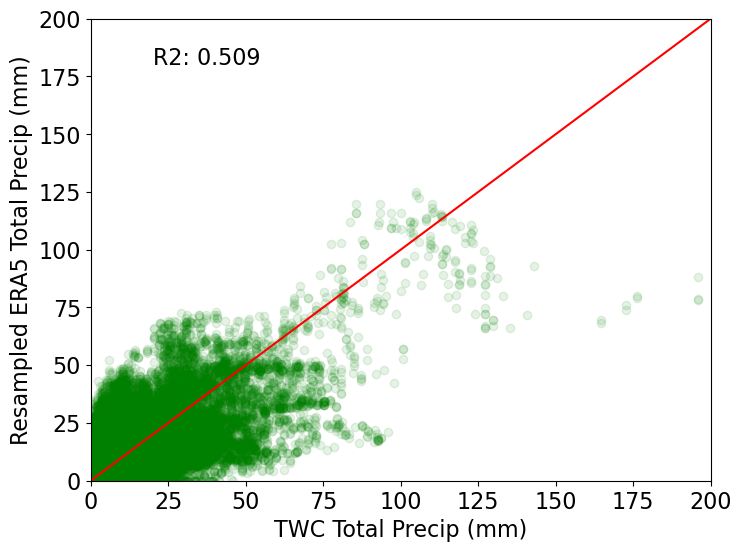

In [4]:
rmse = calculate_rmse(Y_pred=combined_df['total_precip_era5'], Y_obsv=combined_df['total_precip_twc'])
r2 = calculate_r2(Y_pred=combined_df['total_precip_era5'], Y_obsv=combined_df['total_precip_twc'])

print('RMSE before modeling = {:.3f}'.format(rmse))
print('R2 before modeling= {:.3f}'.format(r2))

scatter_plot(Y_pred=combined_df['total_precip_era5'], Y_obsv=combined_df['total_precip_twc'], 
             xlabel='TWC Total Precip (mm)', 
             ylabel='Resampled ERA5 Total Precip (mm)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, color_format='go', axis_lim=[0, 200])

## Goal

The R2 value between TWC and ERA5 total precipitation is not good. We will try Machine Learning model to see if we can use ERA5 datasets as predictors to predict high resolution preceipitation TWC precipitation (8km) as the training data.

--------------------------

## 4. Making train-test split

__Input variables:__ Improved weather variables from ML models (not ERA5 resampled datasets), topography, lat/lon, and month datasets have been used as input variables/predictors in the ML model. 

__Observed/training data:__ TWC `Total Precipitation` has been used as the training/observed data.

In [5]:
drop_columns = ['index', 'year', 'avg_ST_L1', 'avg_SM_L1',
                'max_atmPress', 'min_atmPress', 'min_wind_speed', 'max_wind_speed', 'avg_atmPress',
                'min_wind_speed', 'max_wind_speed', 'min_Rhumid', 'max_Rhumid', 'avg_snow_depth',
                'eto', 'etr', 'max_dew_temp', 'avg_dew_temp', 'avg_wind_dir', 'min_temp',
                'day', 'MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect',
                'avg_Cloud', 'min_dew_temp']

x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=combined_dataset, pred_attr='total_precip_twc', 
exclude_columns=drop_columns, test_perc=0.4, validation_perc=0)

Dropping Columns- ['index', 'year', 'avg_ST_L1', 'avg_SM_L1', 'max_atmPress', 'min_atmPress', 'min_wind_speed', 'max_wind_speed', 'avg_atmPress', 'min_wind_speed', 'max_wind_speed', 'min_Rhumid', 'max_Rhumid', 'avg_snow_depth', 'eto', 'etr', 'max_dew_temp', 'avg_dew_temp', 'avg_wind_dir', 'min_temp', 'day', 'MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect', 'avg_Cloud', 'min_dew_temp'] 

Predictors: Index(['avg_Rhumid', 'avg_temp', 'avg_wind_speed', 'elevation', 'lat', 'lon',
       'max_temp', 'month', 'slope', 'total_precip_era5'],
      dtype='object')


__As we are using CV for hyperparameter tuning, not creating any validation dataset.__

In [6]:
print('x_train length', len(x_train))
print('x_test length', len(x_test))
print('x_val length', len(x_val))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of test dates: {len(test_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')

x_train length 625055
x_test length 416640
x_val length 0
num. of training dates: 1628
num. of test dates: 1085
num. of validation dates: 0


## 5. Looking into Mutual Information (MI) score to select preliminary input variables

`MI score` and `feature importance plot` are ways to determine which predictors are most important in predicting the target variable.  The `MI score` and `predictor/feature importance plot` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

total_precip_era5    0.253136
avg_Rhumid           0.162302
max_temp             0.123863
avg_temp             0.107902
month                0.091109
avg_wind_speed       0.037737
lat                  0.024788
elevation            0.021308
slope                0.020186
lon                  0.020126
dtype: float64

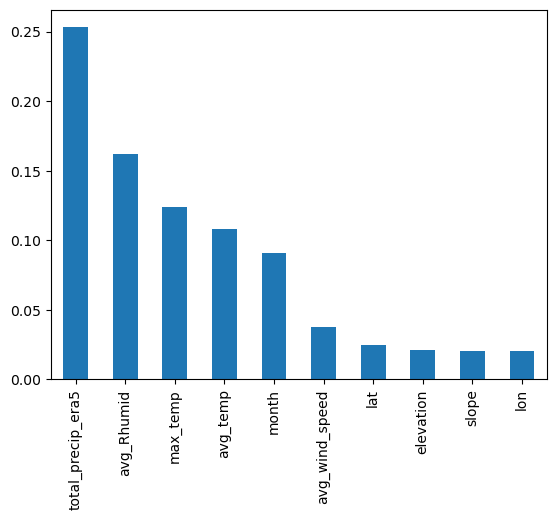

In [7]:
mutual_info_temp = calculate_plot_mutual_information(x_train=x_train, y_train=y_train)
mutual_info_temp

---------------------

## 6. Model training+hyperparamter tuning

Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV. A total of 500 combinations of hyperparameters were tested. The hyperparameter space can be found at `ML_utils.ipynb` script. 

In [6]:
# the hyperparameters provided in the following dictionary have been set by hyperparameter tuning
lgbm_param_dict = {'n_estimators': 250,
                   'max_depth': 13,
                   'learning_rate': 0.05,
                   'subsample': 0.8,
                   'colsample_bytree': 0.7,
                   'colsample_bynode': 0.8 ,
                   'path_smooth': 0.1,
                   'num_leaves': 70,
                   'min_child_samples': 20,
                   'data_sample_strategy': 'goss'
                  }
# when tuning hyperparameters set params_dict=None.
trained_lgbm_precip = train_model(x_train, y_train, params_dict=lgbm_param_dict, model='lgbm', n_jobs=-1,
                                 load_model=False, save_model=True, save_folder='./saved_models', save_name='lgbm_total_precip',
                                 # hyperparameter tuning arguments
                                 tune_hyperparameters=False, repeated_Kfold=False, n_folds=10, n_iter=50, n_repeats=5)

[LightGBM] [Info] Total Bins 1874
[LightGBM] [Info] Number of data points in the train set: 625055, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.977177
Train RMSE = 1.501
Train R2 = 0.894
model training time 0.099 mins


In [7]:
trained_lgbm_precip

LGBMRegressor(colsample_bynode=0.8, colsample_bytree=0.7,
              data_sample_strategy='goss', deterministic=True,
              force_row_wise=True, learning_rate=0.05, max_depth=13,
              n_estimators=250, n_jobs=-1, num_leaves=70, path_smooth=0.1,
              random_state=0, subsample=0.8, tree_learner='serial')

--------------

## 7. Train-test dataset perforamnce evaluation

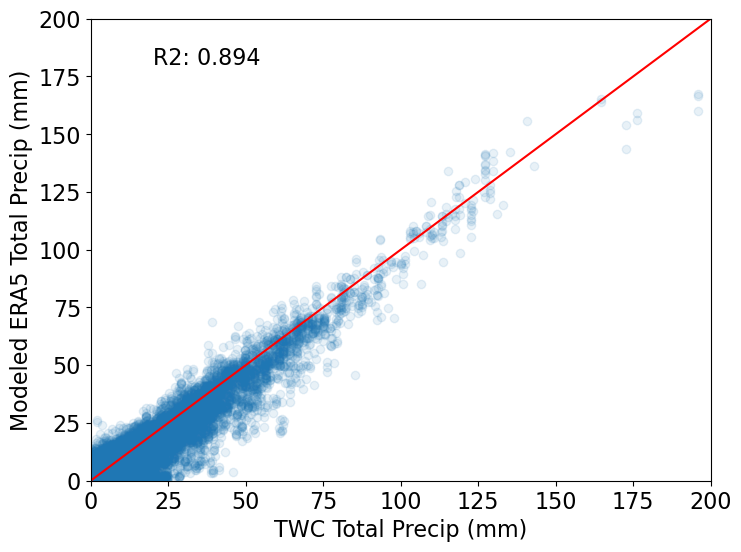

In [8]:
# Performance on train dataset
y_pred_train = trained_lgbm_precip.predict(x_train)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_train, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, axis_lim=[0, 200])

Test RMSE = 2.877
Test R2 = 0.502


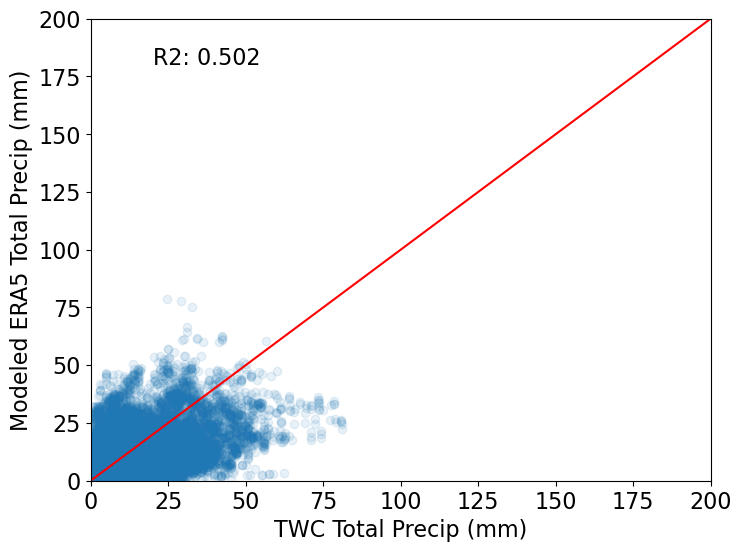

In [9]:
# Performance on test dataset
y_pred_test = trained_lgbm_precip.predict(x_test)
print('Test RMSE = {:.3f}'.format(calculate_rmse(Y_pred=y_pred_test, Y_obsv=y_test)))
print('Test R2 = {:.3f}'.format(calculate_r2(Y_pred=y_pred_test, Y_obsv=y_test)))


scatter_plot(Y_pred=y_pred_test, Y_obsv=y_test, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, axis_lim=[0, 200])

------------------------

## 8. Evaluating model's predictor importance plot

The `predictor/feature importance plot` is a way of seeing which input variables are regarded the most important by the model. The predictor importance plot here is based on `Impurity-based feature importance` which is prone to high-cardinality. I would recoomend looking into [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to have a more rigorous understanding of feature importance. The `predictor/feature importance plot` and `MI score` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

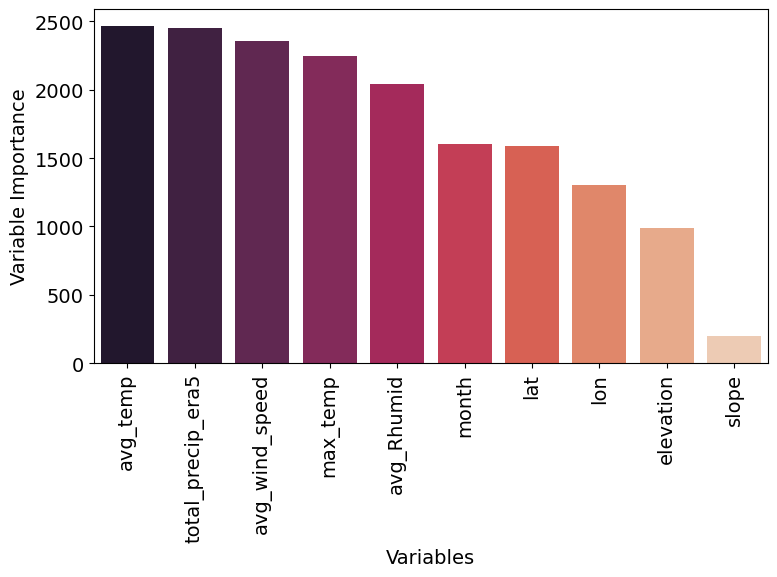

In [17]:
# preditor importance plot
plot_predictor_importance(trained_model=trained_lgbm_precip, x_train=x_train, outdir=None, predictor_imp_keyword='rf')

-----------------

## 9. Evaluation model performance for randomly selected dates from the test dataset

Our objective is to improve spatial resolution of daily weather datasets. So, we chcek model performance on randomly selected dataes from the test datasets.

In [18]:
test_dates[1:20]

[20170212,
 20211116,
 20161216,
 20200822,
 20190919,
 20170721,
 20211216,
 20160102,
 20160413,
 20220104,
 20200218,
 20160714,
 20200308,
 20200228,
 20181125,
 20190801,
 20171123,
 20210828,
 20170218]

In [19]:
if 20160116 in test_dates:
    print(True)

True


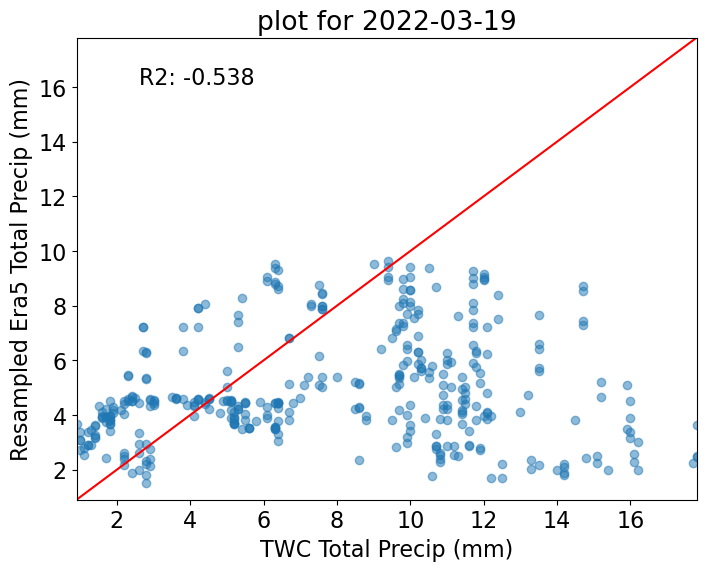

In [11]:
twc_era5_df_sample2 = combined_df[combined_df.date==20220319]
era5_precip = twc_era5_df_sample2['total_precip_era5'] 
y_02 = twc_era5_df_sample2[['total_precip_twc']].values

scatter_plot(Y_pred=era5_precip, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Resampled Era5 Total Precip (mm)', 
             title='plot for 2022-03-19')

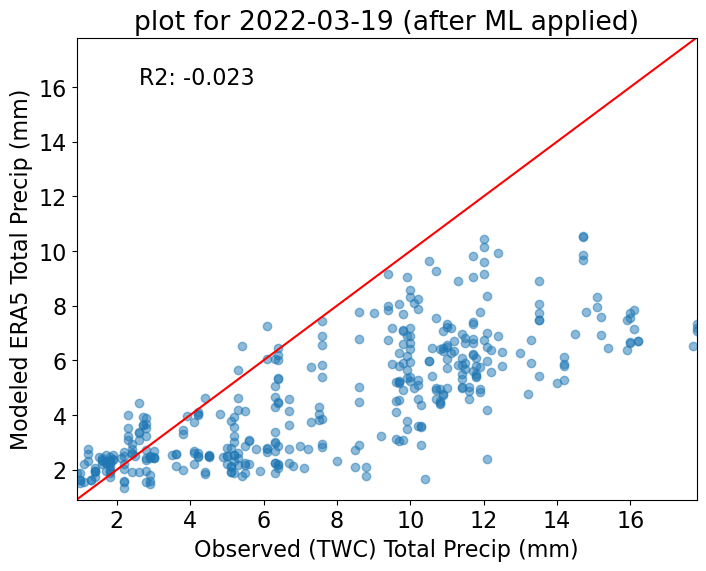

In [12]:
twc_era5_df_sample = combined_df[combined_df.date==20220319]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['total_precip_twc']].values

y_pred_train_20230304 = trained_lgbm_precip.predict(x_02)

scatter_plot(Y_pred=y_pred_train_20230304, Y_obsv=y_02, 
             xlabel='Observed (TWC) Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', 
             title='plot for 2022-03-19 (after ML applied)', 
             savedir=None, plot_name=None)

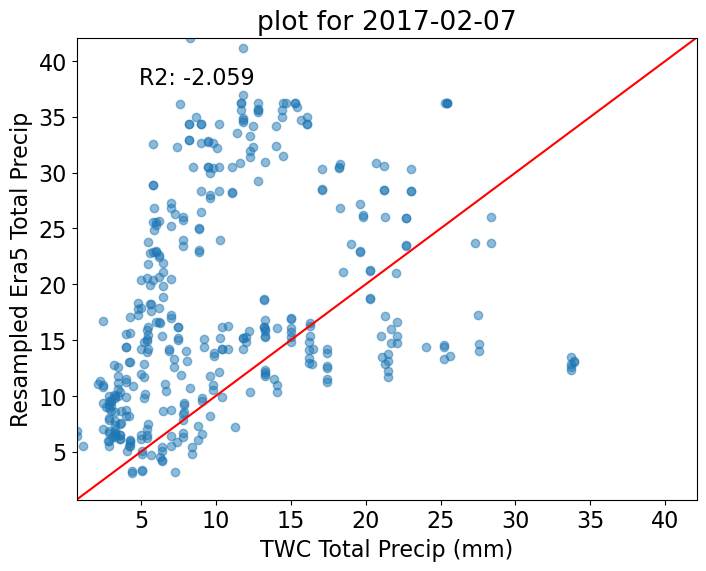

In [13]:
twc_era5_df_sample = combined_df[combined_df.date==20170207]
era5_precip = twc_era5_df_sample['total_precip_era5'] 
y_02 = twc_era5_df_sample[['total_precip_twc']].values

scatter_plot(Y_pred=era5_precip, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Resampled Era5 Total Precip', 
             title='plot for 2017-02-07')

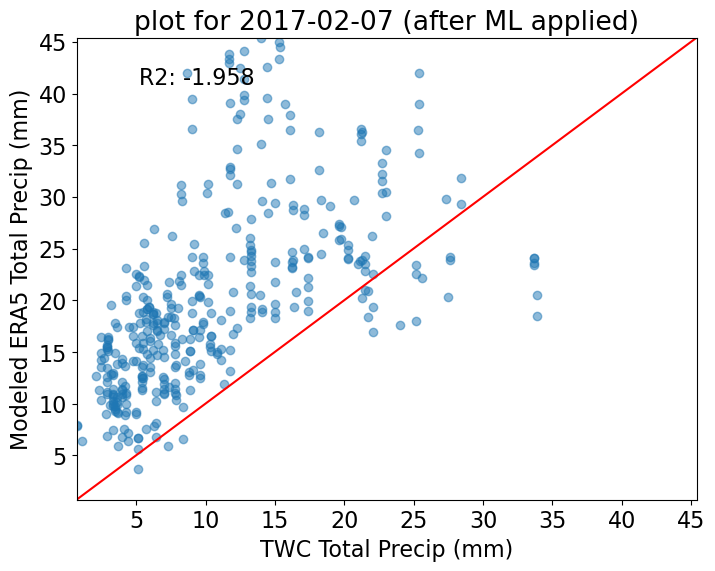

In [10]:
twc_era5_df_sample = combined_df[combined_df.date==20170207]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['total_precip_twc']].values

y_pred_train = trained_lgbm_precip.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', 
             title='plot for 2017-02-07 (after ML applied)', 
             savedir=None, plot_name=None)

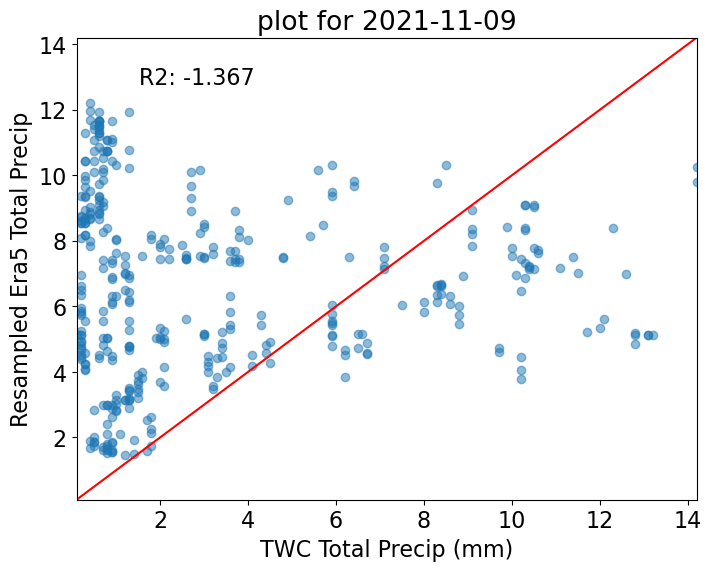

In [18]:
twc_era5_df_sample2 = combined_df[combined_df.date==20211109]
era5_precip = twc_era5_df_sample2['total_precip_era5'] 
y_02 = twc_era5_df_sample2[['total_precip_twc']].values

scatter_plot(Y_pred=era5_precip, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Resampled Era5 Total Precip', 
             title='plot for 2021-11-09')

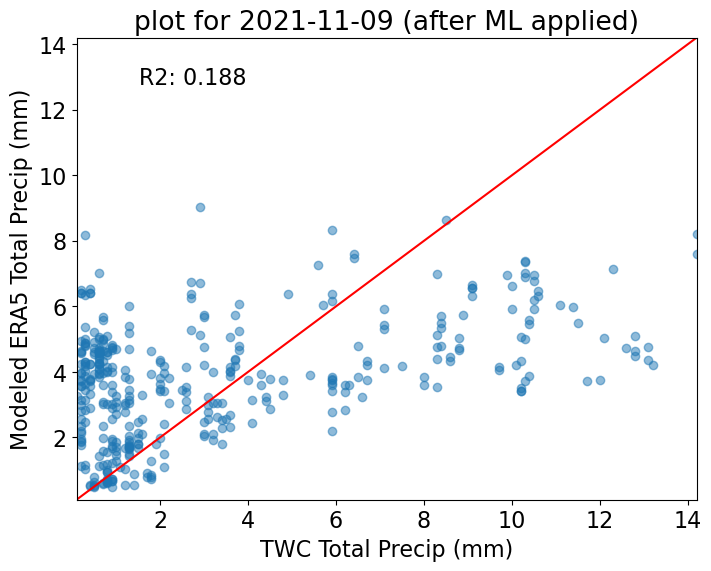

In [11]:
twc_era5_df_sample2 = combined_df[combined_df.date==20211109]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['total_precip_twc']].values

y_pred_train_20230304 = trained_lgbm_precip.predict(x_02)

scatter_plot(Y_pred=y_pred_train_20230304, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', 
             title='plot for 2021-11-09 (after ML applied)', 
             savedir=None, plot_name=None)

__The plots of before and after modeling performance for randomly selected dates from test dataset shows that the model is not performing well for individual dates.__

## 10. Estimating overall model perforamcne on test dataset

As the model isn't performing well, we skipped checking this step

-----------------

# Deep Leaning (MLP) model for `total precipitation`

__Install pytorch first if not already installed__

In [25]:
# !pip3 install torch torchvision torchaudio

In [13]:
from ipynb.fs.full.NN_Pytorch import *

In [14]:
combined_dataset = '../../datasets/processed_parquet_data/cities_California/twc_era5_modeled_precip_data_cities_California_updated.parquet'
combined_df = pd.read_parquet(combined_dataset)

print(f'Combined df columns: {combined_df.columns}')

Combined df columns: Index(['lon', 'lat', 'total_precip_twc', 'date', 'avg_wind_dir', 'etr',
       'avg_ST_L1', 'avg_snow_depth', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'MaxNet_SR', 'elevation', 'min_Rhumid',
       'min_dew_temp', 'max_atmPress', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip_era5', 'eto', 'min_atmPress', 'slope',
       'avg_Cloud', 'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR',
       'index', 'avg_wind_speed', 'year', 'month', 'day', 'avg_Rhumid',
       'max_temp', 'avg_temp', 'min_temp'],
      dtype='object')


### Note********
- Here in the compiled dataframe, the `'index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'avg_temp', 'min_temp'` columns come from the model interpolated improved  weather data dataframe.
- `'total_precip_twc', 'min_wind_speed', 'total_precip_era5', 'MaxNet_SR', 'elevation', 'min_Rhumid',
   'min_dew_temp', 'max_atmPress', 'avg_wind_dir', 'etr', 'avg_ST_L1',
   'avg_snow_depth', 'max_Rhumid', 'TotDown_SR', 'eto', 'min_atmPress',
   'slope', 'avg_Cloud', 'max_wind_speed', 'aspect', 'MaxDown_SR',
   'TotNet_SR', 'avg_atmPress', 'max_dew_temp', 'avg_SM_L1',
   'avg_dew_temp'` comes from previously compiled dataframe. 
- `'total_precip_twc'` is observed TWC precipitation data at 8km spatial resolution.
- `'total_precip_era5'` is ERA5 precipitation data at 8km (resampled from 28km) spatial resolution.

------------------

## 2. Additional data filtering (if required)

No additional filtering was required/performed before splitting data into train-test set.

-----------------

## 3. Evaluation before model performance/relationship

Same as the green scatter plot between `resampled ERA5 total precipitation (8km) vs TWC total precipitation (8km)`

-------------------

## 5. Train-validation-test Split

The `combined dataset` parquet file consists of improved weather datasets from  ML models, resampled weather datasets from ERA5, topography, lat/lon, and month data. It also has TWC Precipitation data to be used as target ariable. The dataset only consists of data starting from 2015.

__Input variables:__ Improved weather variables from ML models, some ERA5 resampled datasets, topography, lat/lon, and month datasets have been used as input variables/predictors in the ML model. 

__Observed/training data:__ TWC `Total Precipitation` has been used as the training/observed data.

In [15]:
drop_columns = ['index', 'year', 'avg_ST_L1', 'avg_SM_L1', 
                'min_wind_speed', 'max_wind_speed', 'avg_snow_depth',
                'eto', 'etr', 'max_dew_temp', 'avg_wind_dir', 'min_temp',
                'day', 'MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect',
                'min_dew_temp']

x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=combined_df, pred_attr='total_precip_twc', 
exclude_columns=drop_columns, test_perc=0.2, validation_perc=0.3)

Dropping Columns- ['index', 'year', 'avg_ST_L1', 'avg_SM_L1', 'min_wind_speed', 'max_wind_speed', 'avg_snow_depth', 'eto', 'etr', 'max_dew_temp', 'avg_wind_dir', 'min_temp', 'day', 'MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'aspect', 'min_dew_temp'] 

Predictors: Index(['avg_Cloud', 'avg_Rhumid', 'avg_atmPress', 'avg_dew_temp', 'avg_temp',
       'avg_wind_speed', 'elevation', 'lat', 'lon', 'max_Rhumid',
       'max_atmPress', 'max_temp', 'min_Rhumid', 'min_atmPress', 'month',
       'slope', 'total_precip_era5'],
      dtype='object')


In [16]:
print('x_train length', len(x_train))
print('x_test length', len(x_test))
print('x_val length', len(x_val))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of test dates: {len(test_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')

x_train length 520607
x_test length 208512
x_val length 312576
num. of training dates: 1356
num. of test dates: 543
num. of validation dates: 814


-------------------

## 5. Loading data in Dataloader

Here, we load the train-validation-test datasets in a Dataloader. We decided a batch size of `128`. But we encourgae to check out with other batch size, such as 32/64/256 to optimize model performance.

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_features = torch.tensor(np.array(x_train)).float()
train_target = torch.tensor(np.array(y_train)).float()
train_dataset = TensorDataset(train_features, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_features = torch.tensor(np.array(x_test)).float()
test_target = torch.tensor(np.array(y_test)).float()
test_dataset = TensorDataset(test_features, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

valid_features = torch.tensor(np.array(x_val)).float()
valid_target = torch.tensor(np.array(y_val)).float()
valid_dataset = TensorDataset(valid_features, valid_target)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

-----------------------

## 6. Model training

I adjusted the architectures and hyperparameters, such as hidden layers, nodes in hidden layers, weight decay, learning rate, manually and decided architecture-hyperparameters that was giving the best model result. I strongly encourage performing a `Grid Search` type search with different types of architectures and hyperparameters. This will help with finding the best set of architecture and hyperparameters and model performance will definitely improve.

In [35]:
nn_model = NeuralNetwork(n_inputs=17, n_hiddens_list=[20, 10], n_outputs=1, dropout=0.1,
                         activation_func='relu', device='cuda')

trained_nn_precip, train_losses, valid_losses, train_mean, train_std = \
train_model(model=nn_model, train_dataloader=train_dataloader, 
            save_folder='./saved_models', savename='nn_precip',
            validation_dataloader=valid_dataloader, patience=10,
            n_epochs=100, method='adam', weight_decay=0.01, learning_rate=0.00001,
            device='cuda', verbose=True, early_stop=True, standardization=True)

Model running on cuda....
avg. MSE Loss in epoch 1: train loss: 25.72169889454818 | validation loss: 12.138686234616085
Validation loss decreased (inf --> 12.138686).  Saving model ...
avg. MSE Loss in epoch 2: train loss: 24.958237704056412 | validation loss: 11.72359586847096
Validation loss decreased (12.138686 --> 11.723596).  Saving model ...
avg. MSE Loss in epoch 3: train loss: 24.16272850605979 | validation loss: 11.134133930020003
Validation loss decreased (11.723596 --> 11.134134).  Saving model ...
avg. MSE Loss in epoch 4: train loss: 23.251120966939784 | validation loss: 10.525246963437557
Validation loss decreased (11.134134 --> 10.525247).  Saving model ...
avg. MSE Loss in epoch 5: train loss: 22.283788177801007 | validation loss: 10.057669886528009
Validation loss decreased (10.525247 --> 10.057670).  Saving model ...
avg. MSE Loss in epoch 6: train loss: 21.340243452520514 | validation loss: 9.110810114558499
Validation loss decreased (10.057670 --> 9.110810).  Saving

avg. MSE Loss in epoch 57: train loss: 12.962644151372103 | validation loss: 7.651885342419593
EarlyStopping counter: 7 out of 10
avg. MSE Loss in epoch 58: train loss: 12.962410151424693 | validation loss: 5.280059524976702
EarlyStopping counter: 8 out of 10
avg. MSE Loss in epoch 59: train loss: 12.926948185524537 | validation loss: 5.236180099168621
EarlyStopping counter: 9 out of 10
avg. MSE Loss in epoch 60: train loss: 13.03183763691442 | validation loss: 6.003115203612463
EarlyStopping counter: 10 out of 10
Early stopping
model training time 7.881 mins


### comment on `Early Stopping`:

I implemented something `unconventional` in `early stopping` in this model. From multiple training runs, I noticed that the training stops early with conventional early stopping. This happens because at a random epoch the validation loss might get very low and the model uses that validation loss to check early stopping criteria. At that point, the training loss might not be minimized and there is large gap between train and validation loss. I ran models for a good number of epochs without early stopping and noticed that even after that very low (sudden) validation loss point training loss decreases and validation loss becomes more generalized (the gap between train and valiation loss decreases). In my thought, we should let the model train for some epochs and then start monitoring `early stopping`. That's why I incorporated `start_EarlyStop_count_from_epoch` argument in the `train_model()` function for the neural network.  

I experimented with different model architecture with 02/03/04 hidden layers, nodes going from 10-100, and learning rates 0.01-0.00001. The [20, 10] architecture with learning rate 0.00001 provided me the best performance. But may be a differnt architecture and hyperparameters set will provide better performance and `conventional early stopping` can be implemented instead of `unconventional early stopping`.

--------------

## 7. Train-validation-test dataset perforamnce evaluation

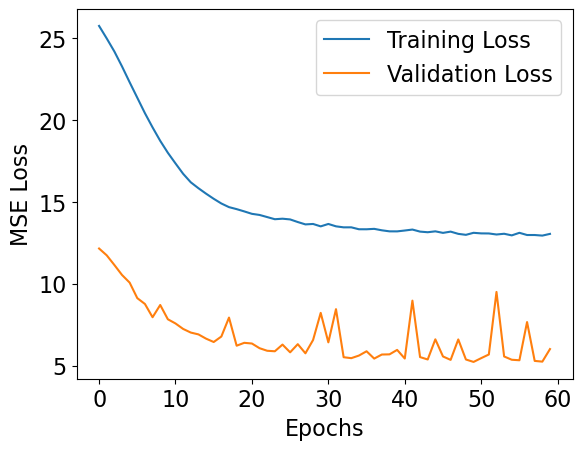

In [20]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Training Loss')
ax.plot(valid_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.legend()

### 7a. Performance on train-test dataset

Now, I load the trained model and check performance of both train and test dataset.

In [18]:
# model structure initialization
nn_model = NeuralNetwork(n_inputs=17, n_hiddens_list=[20, 10], n_outputs=1, dropout=0.1,
                         activation_func='relu', device='cuda')

# loading trained model
trained_nn_precip, train_losses, valid_losses, train_mean, train_std = \
load_trained_model(model_initialized=nn_model, model_path='./saved_models/nn_precip.pt', 
                   train_loss_path='./saved_models/nn_precip_trainloss.pkl', 
                   validation_loss_path='./saved_models/nn_precip_validationloss.pkl', 
                   train_mean_path='./saved_models/nn_precip_trainmean.pkl', 
                   train_std_path='./saved_models/nn_precip_trainstd.pkl', 
                   standardization=True, train_scaler_path=None)

Model running on cuda....
*****Trained model loaded and evaluation mode activated*****


In [19]:
from sklearn.metrics import mean_squared_error, r2_score

device='cuda'
mse_func = torch.nn.MSELoss()  # mse function

trained_nn_precip.eval() # trained model in evaluadtion mode

train_features = train_features
test_features = test_features
train_target = train_target.reshape(-1, 1)
test_target = test_target.reshape(-1, 1)
 
# Standardization and moving to cuda (if device is cuda)
Xs_train = (train_features - train_mean) /  train_std
Xs_train = Xs_train.to(device)

Xs_test = (test_features - train_mean) /  train_std
Xs_test = Xs_test.to(device)

# Prediction on train and test dataset
Y_train_pred = trained_nn_precip(Xs_train).cpu().detach()
Y_test_pred = trained_nn_precip(Xs_test).cpu().detach()


# calculating MSE and RMSE
train_mse = mse_func(Y_train_pred, train_target).item() 
train_rmse = mean_squared_error(y_true=train_target, y_pred=Y_train_pred, squared=False)    

test_mse = mse_func(Y_test_pred, test_target).item() 
test_rmse = mean_squared_error(y_true=test_target, y_pred=Y_test_pred, squared=False)    


# making list of predictions
train_observed = train_target.numpy().flatten().tolist()
train_predicted = Y_train_pred.numpy().flatten().tolist()


test_observed = test_target.numpy().flatten().tolist()
test_predicted = Y_test_pred.numpy().flatten().tolist()
    
print('Train MSE :', train_mse)
print('Train RMSE:', train_rmse)
print('Test MSE :', test_mse)
print('Test RMSE:', test_rmse)

Train MSE : 9.723296165466309
Train RMSE: 3.1182196
Test MSE : 6.921926975250244
Test RMSE: 2.6309555


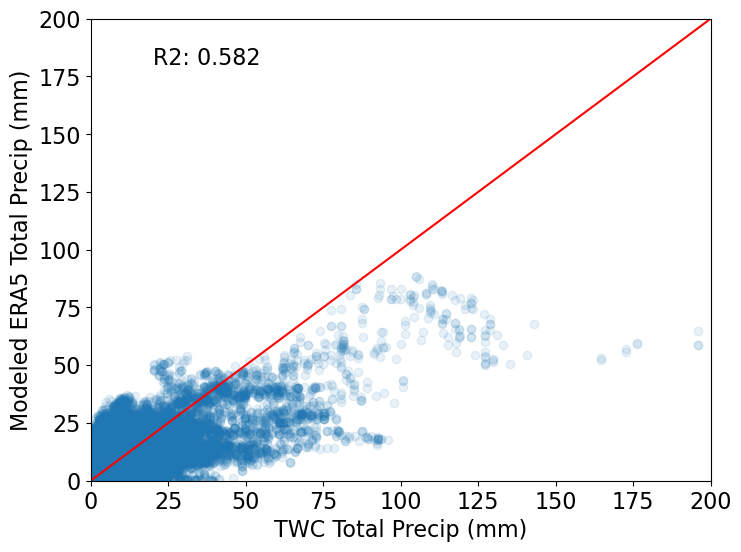

In [20]:
train_observed = pd.Series(train_observed)
train_predicted = pd.Series(train_predicted)

scatter_plot(Y_pred=train_predicted, Y_obsv=train_observed, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)',
             title=None, alpha=0.1, axis_lim=[0, 200])

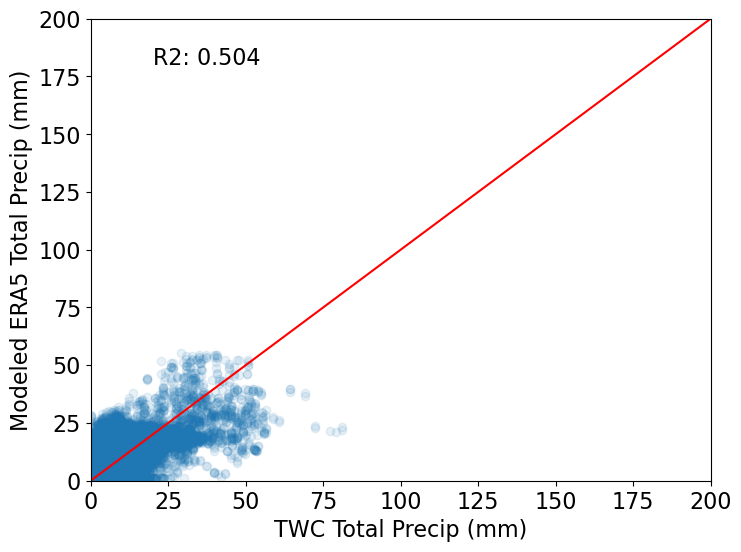

In [21]:
test_observed = pd.Series(test_observed)
test_predicted = pd.Series(test_predicted)

scatter_plot(Y_pred=test_predicted, Y_obsv=test_observed, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)',
             title=None, alpha=0.1, axis_lim=[0, 200])

The train-test scatter plot shows that the model isn't overfitting. The R2 values of the train and test datasets show that the model results in same R2 value as before modeling (green scatter plot) stage. This indicates that the model isn't learning anything useful.

### 7b. Performance on invidual dates from test dataset

In [41]:
test_dates

[20170719,
 20180427,
 20170429,
 20160911,
 20181121,
 20160210,
 20170614,
 20160528,
 20180103,
 20190511,
 20170407,
 20160326,
 20160919,
 20160215,
 20160118,
 20171116,
 20181208,
 20180319,
 20161028,
 20170629,
 20170814,
 20170617,
 20190714,
 20190703,
 20170113,
 20170828,
 20190724,
 20190514,
 20160914,
 20170822,
 20170508,
 20160506,
 20161102,
 20190517,
 20170410,
 20160116,
 20180523,
 20170307,
 20180202,
 20171117,
 20170212,
 20160526,
 20170623,
 20181110,
 20170128,
 20161021,
 20180628,
 20170925,
 20161115,
 20170220,
 20190723,
 20151218,
 20180618,
 20180530,
 20180419,
 20180822,
 20190429,
 20161110,
 20180520,
 20161009,
 20180126,
 20170224,
 20160519,
 20171030,
 20190730,
 20160412,
 20190105,
 20190607,
 20160217,
 20181010,
 20161111,
 20161231,
 20181126,
 20161224,
 20161220,
 20180911,
 20160329,
 20180823,
 20180904,
 20160717,
 20190106,
 20151222,
 20181024,
 20190222,
 20160807,
 20160731,
 20180718,
 20160105,
 20170716,
 20171002,
 20170421,

In [42]:
if 20170207 in test_dates:
    print(True)

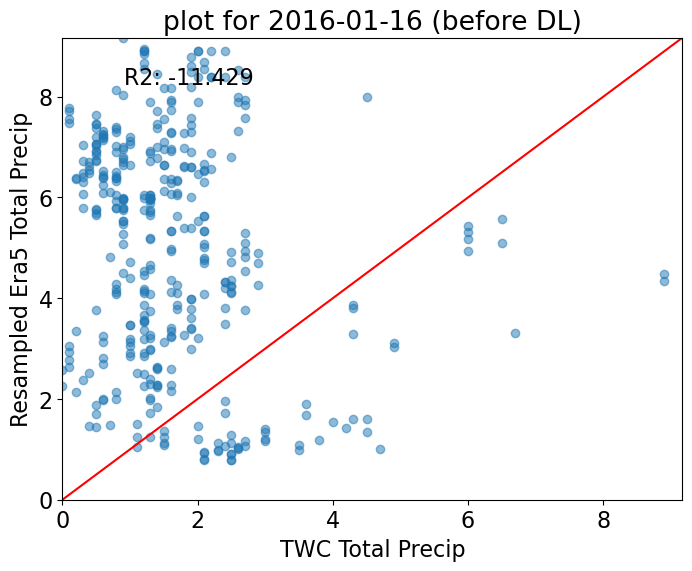

In [32]:
twc_era5_df_sample2 = combined_df[combined_df.date==20160116]
era5_precip = twc_era5_df_sample2['total_precip_era5'] 
y_02 = twc_era5_df_sample2[['total_precip_twc']].values

scatter_plot(Y_pred=era5_precip, Y_obsv=y_02, 
             xlabel='TWC Total Precip', ylabel='Resampled Era5 Total Precip', 
             title='plot for 2016-01-16 (before DL)')

Model predeiction (type: torch tensor) generated and moved to cpu 



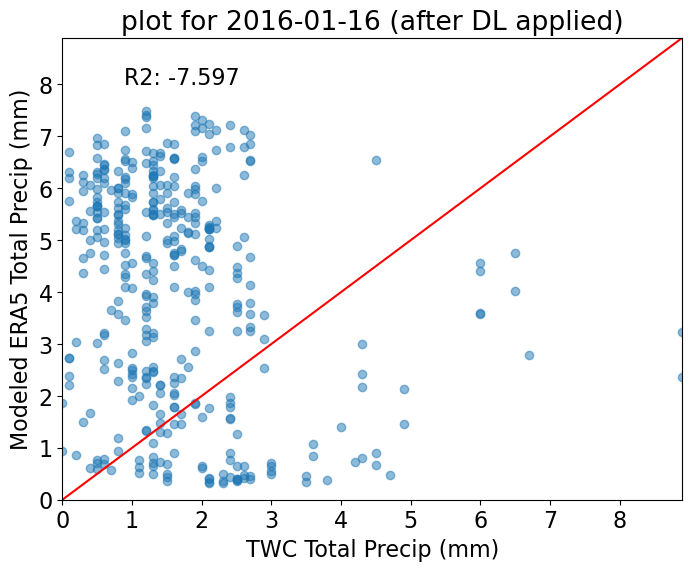

In [22]:
twc_era5_df_sample = combined_df[combined_df.date==20160116]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['total_precip_twc']].values

y_pred_train = predict(trained_nn_model=trained_nn_precip, input_df=x_02, mean=train_mean, std=train_std, 
                       standardize=True, normalize_scaler=None, device='cuda')

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', 
             title='plot for 2016-01-16 (after DL applied)', 
             savedir=None, plot_name=None)

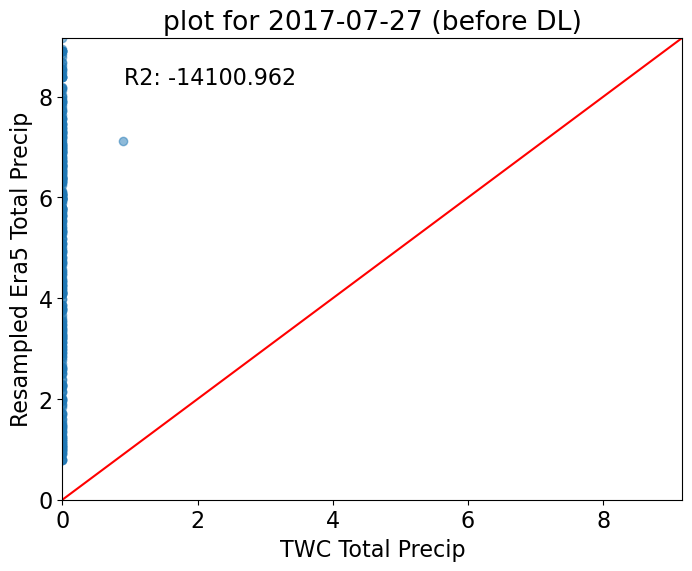

In [34]:
twc_era5_df_sample = combined_df[combined_df.date==20170727]
y_02 = twc_era5_df_sample[['total_precip_twc']].values

scatter_plot(Y_pred=era5_precip, Y_obsv=y_02, 
             xlabel='TWC Total Precip', ylabel='Resampled Era5 Total Precip', 
             title='plot for 2017-07-27 (before DL)')

Model predeiction (type: torch tensor) generated and moved to cpu 



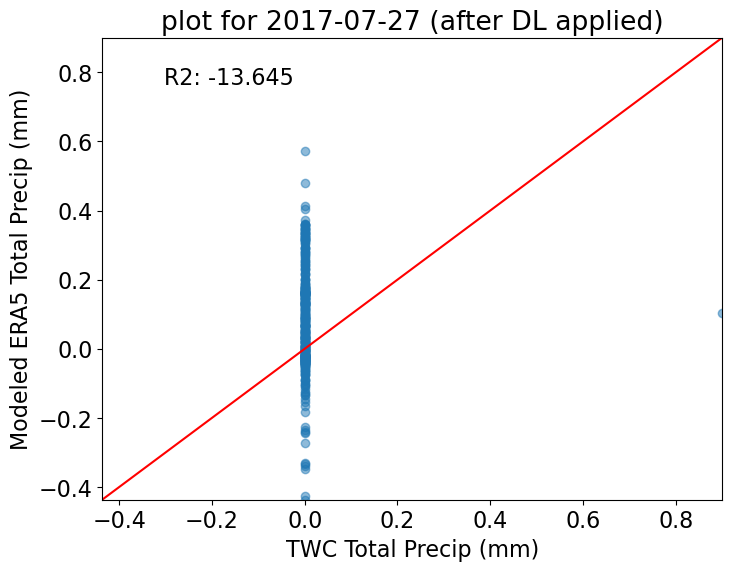

In [23]:
twc_era5_df_sample = combined_df[combined_df.date==20170727]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['total_precip_twc']].values

y_pred_train = predict(trained_nn_model=trained_nn_precip, input_df=x_02, mean=train_mean, std=train_std, 
                       standardize=True, normalize_scaler=None, device='cuda')

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Total Precip (mm)', 
             title='plot for 2017-07-27 (after DL applied)', 
             savedir=None, plot_name=None)

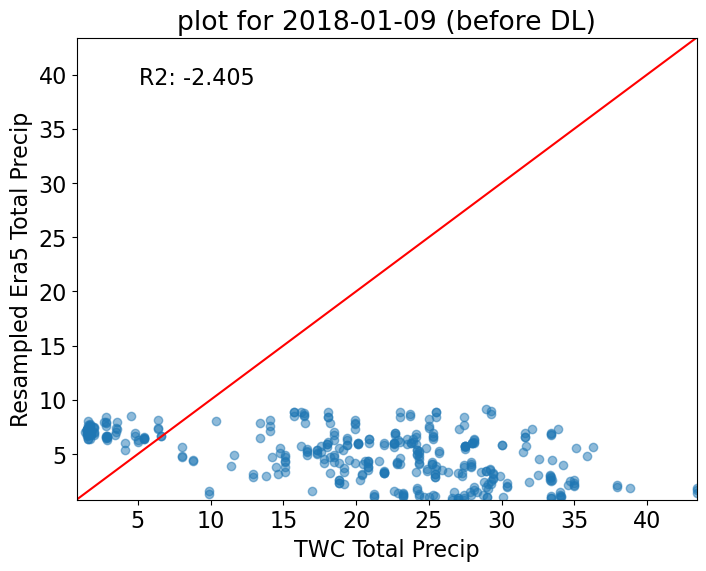

In [36]:
twc_era5_df_sample = combined_df[combined_df.date==20180109]
y_02 = twc_era5_df_sample[['total_precip_twc']].values

scatter_plot(Y_pred=era5_precip, Y_obsv=y_02, 
             xlabel='TWC Total Precip', ylabel='Resampled Era5 Total Precip', 
             title='plot for 2018-01-09 (before DL)')

Model predeiction (type: torch tensor) generated and moved to cpu 



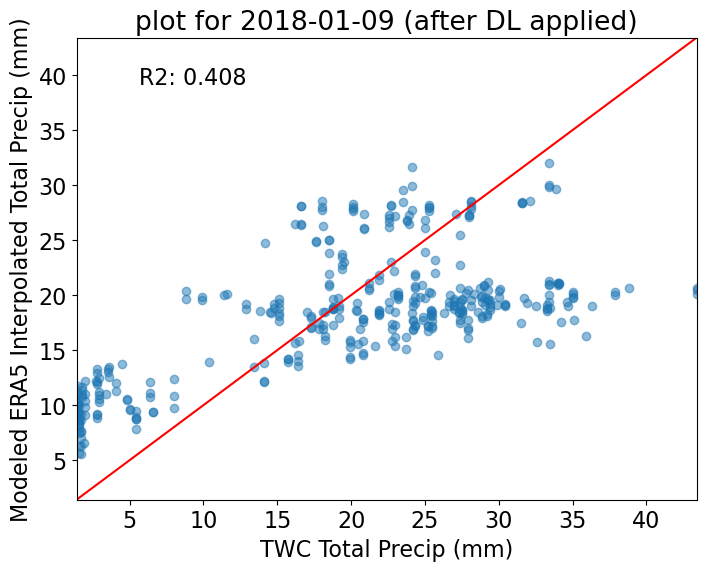

In [24]:
twc_era5_df_sample = combined_df[combined_df.date==20180109]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['total_precip_twc']].values

y_pred_train = predict(trained_nn_model=trained_nn_precip, input_df=x_02, mean=train_mean, std=train_std, 
                       standardize=True, normalize_scaler=None, device='cuda')

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Total Precip (mm)', ylabel='Modeled ERA5 Interpolated Total Precip (mm)', 
             title='plot for 2018-01-09 (after DL applied)', 
             savedir=None, plot_name=None)

__comment:__ The daily performance comparison, with Deep Learning model applied, shows no improvement in daily total precipitation prediction.

## Thoughts on the Precipitation Model

Overall, both the ML and DL models didn't do well for interpolating the precipitation data to high resolution. The LGBM ML model overfits the training data quickly and that affects model performance on test dataset. The DL model improves model performance in terms of overfitiing and both the training-testing perforamnce are nearly the same. But still it isn't performing well in interpolating daily precipitation data.

## Things Tried to Improve Model Performance

#### Data
- __First, we tried to train the model with original ERA5 resampled weather datasets, topography, lat/lon, and month data. But that model wasn't performing well.__
- __Second, we tried incorporating improved input variables/predictors into the model. As improved weather variables, I replaced (see section 1 of the ML (GOSS) model) the original ERA5 resampled avg. wing speed, avg. relative humidity, min/max/avg temperature datasets with ML model improved/interpolated datasets (see the ML scripts in the folder). In this new input variable dataset, there are other variables, such as total_precipitation_era5, avg_Cloud, avg_atmPress, avg_dew_temp, max_Rhumid, max_atmPress, min_Rhumid, min_atmPress variables (resampled directly from ERA5 28km dataset), topographic variables (elavation, slope), lat/lon, and month. The topographic datasets have been interpolated directly from high resolution (30m) SRTM DEM data.__  
- Trained the model for the dataset spanning from Dec, 2015- July, 2019 as the precipitation data from Aug, 2019 have resolution issues. Also, tried training the model with the whole dataset spanning from Dec, 2015 - 2023. Performance for the model with timespan Dec, 2015- July, 2019  is better comparatively.


    
#### Model parameters    
- Tried different ratios of train-validation-test split. 
- The precipitation training data holds more precipitation values of zero and close to zeros than higher precipitation values, making the dataset imbalanced. Tried undersampling of precipitation training data to make the dataset balanced but it failed to improve performance.
- Tried different learning rates
- Tried simple and complex architecture
- Tried with/without dropout layer. Dropout value with 0.1 does better,
- Tried with/without early stopping. Early stopping does better.
- Tried different optimizers
   - for SGD: momentum 0.9, weight_decay 0.01, others default
   - for Adam: weight_decay 0.01, others default
- Tried different values of momentum and weight_decay

 

 
## Future directions
- The precipitation training (observed) dataset is highly skewed with many zero values. According to [this article](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)'s very last plot, our precipitaion model in of unknown fit (our train-validation loss plot show similar trend), meaning that the validation dataset is easier for the model to predict than the training dataset. Data splitting strategy that deals with skewed datasets might be helpful in this case.
- Incorporate more datasets. We only used 4 years of data (2015-2019) for model training-validation-testing. As the precipitation training dataset if 8km resolution, the number of samples in the dataset is much lower than that of other weather models (the other weather models have datasets at 4km resolution, so more number of pixels available for training). It is recommended to incorporate more records to have better model performance.
- As the train-validation performance is not well, the model might have some missing physics. Moreover, there might be data quality issue in input and training data. Checking quality of input and training data is recommnded. 
- ERA5 datsets are also available at 10km resolution. Collection that datasets including weather variables from other models/satellites/sensors, such as MERRA-2, PRISM, GPM, and NOAA Stage IV radara data, and using them as input variables might increase model performance. 
- Most recent studies use CNN/Unet based architectures for precipitation downscaling. Using such architectures might be a good idea.
- Exploring Sensor/Station data to discover insights.
    
    

## 8. Generating daily high resolution (4km) raster using trained model

### 8a. Loading trained DL model

In [6]:
# model structure initialization
nn_model = NeuralNetwork(n_inputs=17, n_hiddens_list=[20, 10], n_outputs=1, dropout=0.1,
                         activation_func='relu', device='cuda')

# loading trained model
trained_nn_precip, train_losses, valid_losses, train_mean, train_std = \
load_trained_model(model_initialized=nn_model, model_path='./saved_models/nn_precip.pt', 
                   train_loss_path='./saved_models/nn_precip_trainloss.pkl', 
                   validation_loss_path='./saved_models/nn_precip_validationloss.pkl', 
                   train_mean_path='./saved_models/nn_precip_trainmean.pkl', 
                   train_std_path='./saved_models/nn_precip_trainstd.pkl', 
                   standardization=True, train_scaler_path=None)

Model running on cuda....
*****Trained model loaded and evaluation mode activated*****


### 8b. Replacing with model interpolated datasets in ERA5 dataset

The `combined dataset` parquet file, which I used to train the model, consists of improved weather datasets from  ML models, resampled weather datasets from ERA5, topography, lat/lon, and month data as predictor/input variables. It also has TWC Precipitation data to be used as target ariable and the dataset only consists of data starting from 2015. For generating daily precipitation dataset using the model, we don't need the TWC precipitation data (as it was the training/taget data) but we need the input variables from 2002. Therefore, we are doing the following step-


__The `downscaled_weather_data_8km.parquet` file have the ML model interpolated improved weather variables avg relative humidity, avg wind speed, avg temperature, min temperature, max temperature. The `8km_era5_daily_data.parquet` file consists of all original ERA5 resampled weather variables including the topography and lat/lon data.

__Replacing resampled ERA5 avg relative humidity, avg wind speed, avg temperature, min temperature, max temperature datasets in `8km_era5_daily_data.parquet` with  `ML model interpolated` improved dataset from  `downscaled_weather_data_8km.parquet`.__

In [7]:
# compiled dataframe with modeled (ML generated) weather variable
model_interpolated_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/downscaled_weather_data_8km.parquet'
model_interpolated_df = pd.read_parquet(model_interpolated_data)

# ERA5 compiled data with weather variables and topography
era5_compiled_data=  '../../datasets/processed_parquet_data/cities_California/era5_parquet/8km_era5_daily_data.parquet'
era5_compiled_df = pd.read_parquet(era5_compiled_data)

# the 'avg_wind_speed', 'avg_Rhumid', 'max_temp', 'min_temp' datasets will come from the model interpolated dataframe
# removing these columns before compiling the dataframes
era5_compiled_df = era5_compiled_df.drop(columns=['avg_wind_speed', 'avg_Rhumid', 'max_temp', 'min_temp'])


final_compiled_dataset = '../../datasets/processed_parquet_data/cities_California/downscaled_era5_weather_data_8km.parquet'

final_combined_df = combine_twc_era5_datasets(twc_dataset=era5_compiled_df, era5_dataset=model_interpolated_df, 
                                        output_file=final_compiled_dataset, 
                                        merge_on=['date', 'lat', 'lon'], how='inner')

print(final_combined_df.columns)
final_combined_df.head()

Index(['avg_wind_dir', 'date', 'etr', 'avg_ST_L1', 'avg_snow_depth', 'lat',
       'lon', 'avg_atmPress', 'max_dew_temp', 'avg_SM_L1', 'avg_dew_temp',
       'MaxNet_SR', 'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_Rhumid', 'TotDown_SR', 'min_wind_speed', 'total_precip', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'max_wind_speed', 'aspect',
       'MaxDown_SR', 'TotNet_SR', 'index', 'avg_wind_speed', 'year', 'month',
       'day', 'avg_Rhumid', 'max_temp', 'avg_temp', 'min_temp'],
      dtype='object')


,avg_wind_dir,date,etr,avg_ST_L1,avg_snow_depth,lat,lon,avg_atmPress,max_dew_temp,avg_SM_L1,...,TotNet_SR,index,avg_wind_speed,year,month,day,avg_Rhumid,max_temp,avg_temp,min_temp
0,151.870132,20020101,0.626299,12.454870,0.0,39.372646,-122.252716,996.609070,12.576299,0.42,...,0.978769,43,7.491530,2002,1,1,95.803848,13.486037,11.461843,9.432428
1,147.454544,20020101,0.661364,12.734091,0.0,39.372646,-122.180717,1004.081787,12.811363,0.42,...,0.970341,44,7.563121,2002,1,1,96.381470,13.621851,11.491751,9.336340
2,143.038956,20020101,0.696429,13.013311,0.0,39.372646,-122.108719,1011.554565,13.046429,0.42,...,0.961912,45,7.780975,2002,1,1,96.771683,13.604365,11.457664,9.242048
3,138.386368,20020101,0.733117,13.210714,0.0,39.372646,-122.036720,1016.683105,13.168507,0.42,...,0.958880,46,7.887574,2002,1,1,96.686722,13.687419,11.496911,9.364754
4,133.022720,20020101,0.774675,13.162663,0.0,39.372646,-121.964722,1014.779236,12.951623,0.42,...,0.972036,47,7.821082,2002,1,1,96.589569,13.803226,11.538865,9.361293


### 8b. Running DL model to generate daily high resolution (8km) total precipitation raster

In [8]:
predictor_dataset = '../../datasets/processed_parquet_data/cities_California/downscaled_era5_weather_data_8km.parquet'
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/total_precip/total_precip_20151204.tif'
output_folder = '../../datasets/downscaled_data/8km/weather_data/modelded_precipitation_8km/total_precip'


run_DL_model_to_generate_prediction(trained_dl_model=trained_nn_precip, standardization_mean=train_mean, standardization_std=train_std, 
                                    x_train=x_train,  predictor_dataset=predictor_dataset, ref_raster=ref_raster, 
                                    output_folder=output_folder, variable_name_keyword='total_precip', 
                                    remove_neg_values=True)

Model predeiction (type: torch tensor) generated and moved to cpu 

Model prediction converted to numpy array
Generating model interpolated daily rasters...
All daily rasters generated


### 8c. Resampling model interpolated daily precipitation raster to 4km

__comment:__ The model generated total precipitation daily rasters are of 8km spatial resolution. But our target resolution is 4km as of other ML model interpolated high resolution (4km) weather datasets. So, we are resampling (bilinear resampling) the 8km rasters to 4km to harmonize.  

In [3]:
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/max_temp/max_temp_20150630.tif'

modeled_precip_8km_dir =  '../../datasets/downscaled_data/8km/weather_data/modelded_precipitation_8km/total_precip'
modelded_precip_8km_datasets = glob(os.path.join(modeled_precip_8km_dir, '*.tif'))

output_4km_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_precipitation_resampled_4km/total_precip'

for data in modelded_precip_8km_datasets:
    raster_name = os.path.basename(data).split('.')[0] + '.tif'
    
    resample_raster_based_on_ref_raster(input_raster=data, ref_raster=ref_raster, output_dir=output_4km_dir, 
                                        raster_name=raster_name, resampling_alg=Resampling.bilinear)

### Visualization of downscaled results 

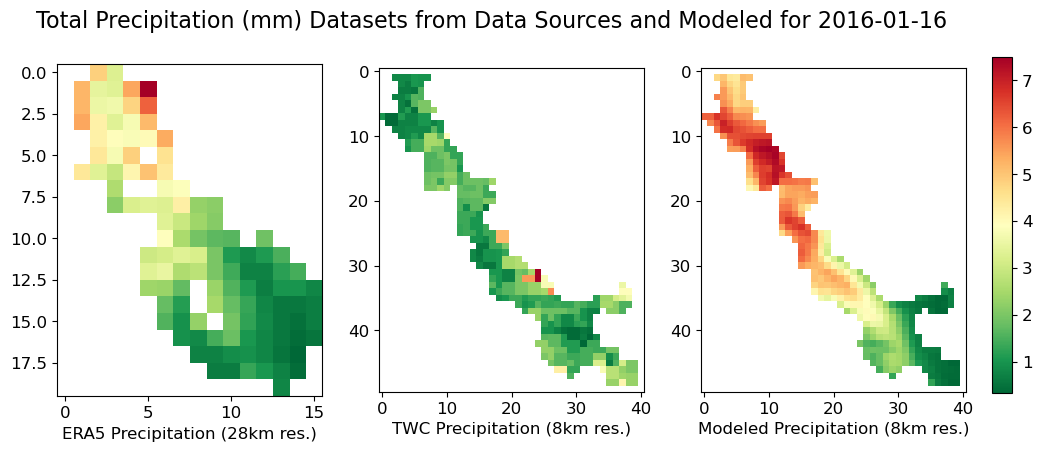

In [9]:
era5_data = '../../datasets/weather_raster_data/cities_California/era5_data/original_28km_rasters/total_precip/total_precip_20160116.tif'
twc_data = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/total_precip/total_precip_20160116.tif'
downscaled_data = '../../datasets/downscaled_data/8km/weather_data/modelded_precipitation_8km/total_precip/total_precip_20160116.tif'


plot_era5_twc_downscaled_rasters(era5_data, twc_data, downscaled_data,  
                                 title= 'Total Precipitation (mm) Datasets from Data Sources and Modeled for 2016-01-16',
                                 suptitle_pos=0.75,
                                 xlabels=['ERA5 Precipitation (28km res.)',
                                          'TWC Precipitation (8km res.)',
                                          'Modeled Precipitation (8km res.)'],
                                 cbar_axes_pos=[1, 0.27, 0.02, 0.42])